In [7]:
# Importing packages
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import numpy as np
import itertools
from ipywidgets import Layout
import seaborn as sns
import math

import time
from scipy import linalg
import scipy.optimize as optimize
import sympy as sm

from tkinter import *
import tkinter as tk

from data_gen import gen_df 


In this project, we want to try to estimate the ratings of movies. That is, we well calculate the utility of a movie, given genres, duration, awards and so forth, and we will try to calculate the IMDB ratings for each movie, based on this utility. Finally, we will then minimize the distance between our estimated ratings and the actual ratings. 

Our utility function is given by: 
$$ U_i = \sum_{k=1}^{23}(\alpha_k G_{ik}) + \sum_{k=1920}^{2010} (\beta_k D_{ik}) + \gamma N_i + \delta W_i + \rho_1 L_i + \rho_2 L_i^2 $$. 

Based on this utility function, we will estimate the ratings of each movies,
$$ R_i^{model} = \frac{\exp(\omega x_i)}{1 + \exp(\omega x_i)} $$ 

where, 
$$ x_i = \big[G_1, G_2, ..., G_n, D_{1920}, D_{1930}, ..., D_{2010}, N_i, W_i, L_i, L_i^2 \big] $$
$$ \omega = \big[\alpha_1, \alpha_2, ..., \alpha_{23}, \beta_{1920}, \beta_{1930}, ..., \beta_{2010}, \gamma, \delta, \rho_1, \rho_2  \big] $$

We then use optimize methods to solve the following: 

$$ \min_{\omega} \Big\{ \sum_{i=1}^{n} \left( R_i^{model} - R_i^{data} \right)^2 \Big\} $$


In [146]:
def df_s(keep_top=None):
    global df
    global decade_list

    filename = 'imdb.csv'

    df = gen_df(filename)

    decade_list = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]

    # Decade dummies
    for i in decade_list:
        df[f'decade_{i}'] = 0
        df.loc[(df['decade'] == f'{i}s'),f'decade_{i}'] = 1

    df = df.loc[(df['ratingCount']>=5000)]
    df = df.drop(columns=['Adult','GameShow','News','RealityTV','TalkShow'])

    if keep_top != None:
        df = df.sort_values('imdbRating', ascending=False)
        df = df.iloc[:keep_top]

    df_X = df.copy()
    df_Y = pd.DataFrame(df[['imdbRating', 'index']].copy())
    df_Y = df_Y.rename(columns = {'imdbRating':'rat_data'})
    """    
    drops = ['index','tid', 'title', 'imdbRating', 'ratingCount', 'year', 
             'nrOfGenre', 'nrOfPhotos', 'nrOfNewsArticles',  'nrOfUserReviews', 'decade']

    for i in drops:
        df_X.drop(columns=[i], inplace=True)
    """
    # Rearrange columns
    df_X = df_X.reindex(['Action','Adventure','Animation','Biography','Comedy','Crime','Documentary',
                              'Drama','Family','Fantasy','FilmNoir','History','Horror','Music','Musical',
                              'Mystery','Romance','SciFi','Short','Sport','Thriller','War','Western',
                              'decade_1920','decade_1930','decade_1940','decade_1950','decade_1960',
                              'decade_1970','decade_1980','decade_1990','decade_2000','decade_2010',
                              'nrOfNominations','nrOfWins','duration'], axis=1)
    
    return df_X, df_Y

df_s()

(       Action  Adventure  Animation  Biography  Comedy  Crime  Documentary  \
 3         0.0        0.0        0.0        0.0     0.0    0.0          0.0   
 13        0.0        0.0        0.0        0.0     1.0    0.0          0.0   
 19        0.0        0.0        0.0        0.0     0.0    0.0          0.0   
 21        0.0        0.0        0.0        0.0     0.0    0.0          1.0   
 32        0.0        0.0        0.0        0.0     1.0    0.0          0.0   
 41        0.0        0.0        0.0        0.0     0.0    0.0          0.0   
 43        1.0        0.0        0.0        0.0     1.0    0.0          0.0   
 45        0.0        0.0        0.0        0.0     0.0    0.0          0.0   
 50        0.0        0.0        0.0        0.0     0.0    0.0          0.0   
 52        0.0        1.0        0.0        0.0     1.0    0.0          0.0   
 53        0.0        1.0        0.0        0.0     0.0    0.0          0.0   
 57        0.0        0.0        0.0        0.0     

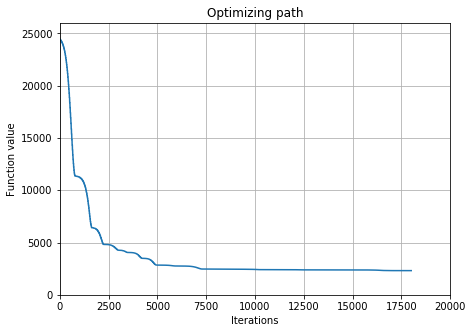

Optimization terminated successfully.
         Current function value: 2312.673790
         Iterations: 18256
         Function evaluations: 21053
Time: 165.1983 seconds


In [157]:
def optimizer(keep_top=None, live_graph=True):
    global fs
    global evals
    global x0
    global df
    global df_Y
    
    def sqr_diff_sum(df_X,pars):
        global df_Y
        util = df_X@pars
        df_Y['rat_model'] = 10*np.exp(util)/(1+np.exp(util))
        df_Y['sqr_diff'] = (df_Y['rat_model']-df_Y['rat_data'])**2
        return df_Y['sqr_diff'].sum()

    # Scipy minimize
    def zeros(n): 
        list = [0] * n
        return list 
    
    if live_graph:
        def live_plot(evals, fs, ymax=10000, figsize=(7,5)):
            clear_output(wait=True)
            plt.figure(figsize=figsize)

            plt.plot(evals, fs)
            plt.title('Optimizing path')
            plt.grid(True)
            plt.xlabel('Iterations')
            plt.ylabel('Function value')
            plt.xlim(0,20000)
            plt.ylim(0,ymax)
            #plt.legend(loc='center left') # the plot evolves to the right
            plt.show();

    def collect(x):
        global fs
        global evals
        global x0
        global fig
        global ax
        global ymax

        if evals == 0:
            fs = []
            fs.append(obj_fun(x0))

        if evals != 0:
            fs.append(obj_fun(x))
        
        if live_graph:
            if evals == 1:
                ymax = math.ceil(obj_fun(x)/2000)*2000

            if evals < 1000:
                if evals > 0 and evals%100 == 0:
                    live_plot(range(evals+1), fs, ymax)
            if evals >=1000:
                if evals%500 == 0:
                    live_plot(range(evals+1), fs, ymax)
        
        evals += 1
    
        
    df_X, df_Y = df_s(keep_top=5000)
    x0 = zeros(36)
    evals = 0
    
    obj_fun = lambda x: sqr_diff_sum(df_X,x)
        
    result = optimize.minimize(obj_fun,x0,
                               method="Nelder-Mead",
                               options={"disp":True, "maxiter":50000}, # display the results
                               callback=collect
                               ) 
    return result

start = time.time()
result = optimizer(keep_top=5000)
print(f'Time: {time.time()-start:.4f} seconds')

result.x

variables = ['Action','Adventure','Animation','Biography','Comedy','Crime','Documentary',
                          'Drama','Family','Fantasy','FilmNoir','History','Horror','Music','Musical',
                          'Mystery','Romance','SciFi','Short','Sport','Thriller','War','Western',
                          'decade_1920','decade_1930','decade_1940','decade_1950','decade_1960',
                          'decade_1970','decade_1980','decade_1990','decade_2000','decade_2010',
                          'nrOfNominations','nrOfWins','duration']

results = dict()


for j,i in enumerate(variables):
    results[i] = result.x[j]

In [185]:
df_true = df.copy()

df_merge = df_true.merge(df_Y, how='right', left_on='index', right_on='index')

df_merge['abs_diff'] = abs(df_merge['rat_data']-df_merge['rat_model'])
df_merge.abs_diff.mean()

def mean_genre(df):  
    genre_list = ['Action','Adventure','Animation','Biography','Comedy','Crime','Documentary',
                              'Drama','Family','Fantasy','FilmNoir','History','Horror','Music','Musical',
                              'Mystery','Romance','SciFi','Short','Sport','Thriller','War','Western']
    mean_dict = dict()
    for i in genre_list:
        I = df[i] == 1
        mean_dict[i]= format(df.loc[I]['abs_diff'].mean(),'.3f')
        
    return mean_dict
    
mean_genre(df_merge)

{'Action': '0.525',
 'Adventure': '0.531',
 'Animation': '0.646',
 'Biography': '0.484',
 'Comedy': '0.507',
 'Crime': '0.493',
 'Documentary': '0.833',
 'Drama': '0.519',
 'Family': '0.613',
 'Fantasy': '0.551',
 'FilmNoir': '0.976',
 'History': '0.538',
 'Horror': '0.500',
 'Music': '0.604',
 'Musical': '0.714',
 'Mystery': '0.483',
 'Romance': '0.557',
 'SciFi': '0.563',
 'Short': '2.927',
 'Sport': '0.507',
 'Thriller': '0.496',
 'War': '0.624',
 'Western': '0.570'}